# Testing learned representation on Eurosat

### Storing and loading and models

In [1]:
import sys
from os.path import isdir, isfile, join
from os import mkdir
from urllib import request
sys.path.append('../src')
from utils.pretrained_checkpoints import saved_ckpts
from utils.progress import ProgressBar
from copy import deepcopy
import shutil
import torch
import tqdm
import numpy as np
import torch.nn.functional as F

In [2]:
pretrained_checkpoint_path = '../src/saved_ckpt'
pretrained_checkpoint_url = 'https://research.cs.cornell.edu/caco/checkpoints/'

In [3]:
model_type = 'r18_1m_seco'
ckpt = saved_ckpts[model_type] # or choose some othe checkpoint

In [4]:
# create a directory for checkpoint 
if not isdir(pretrained_checkpoint_path):
    mkdir(pretrained_checkpoint_path)

def download_checkpoint(ckpt):
    if not isfile(join(pretrained_checkpoint_path, ckpt)):
        print('Checkpoints {0} is not stored. downloading {0}'.format(ckpt))
        request.urlretrieve(join(pretrained_checkpoint_url, ckpt), join(pretrained_checkpoint_path, ckpt), ProgressBar())

download_checkpoint(saved_ckpts[model_type])

Checkpoints resnet18_seco_geo_1m_200.ckpt is not stored. downloading resnet18_seco_geo_1m_200.ckpt


100% |##################################################################################################|


In [5]:
from models.moco2_module import MocoV2

{'min_q': {'B2': 3.0, 'B3': 2.0, 'B4': 0.0}, 'max_q': {'B2': 88.0, 'B3': 103.0, 'B4': 129.0}}


In [6]:
from utils.histogram_callback import HistogramCallback

In [7]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

In [8]:
model = MocoV2.load_from_checkpoint(join(pretrained_checkpoint_path, saved_ckpts[model_type]))
backbone = deepcopy(model.encoder_q).eval().to(device) # get resnet-18 backbone from lightning wrappper

### Downloading Eurosat dataset

In [9]:
from datasets.eurosat_datamodule import EurosatDataModule

In [10]:
data_dir = '../data'
zipfilename = 'EuroSAT_RGB.zip'
eurosatdir = 'EuroSAT_RGB'
downloadurl = 'https://research.cs.cornell.edu/caco/data/eurosat/EuroSAT_RGB.zip'
splitdownloadurl = 'https://research.cs.cornell.edu/caco/data/eurosat'

In [11]:
if not isdir(data_dir):
    print('Created data directory')
    mkdir(data_dir)
if not isfile(zipfilename):
   if not isfile(join(data_dir, zipfilename)):
        print('Eurosat is not stored. downloading')
        request.urlretrieve(downloadurl, join(data_dir, zipfilename), ProgressBar())
if not isdir(join(data_dir, eurosatdir)):
    print('Extracting zipfile. Might take a few minutes')
    shutil.unpack_archive(join(data_dir, zipfilename), data_dir)
    print('downloading splits files')
    request.urlretrieve(join(splitdownloadurl, 'train.txt'), join(data_dir, eurosatdir, 'train.txt'))
    request.urlretrieve(join(splitdownloadurl, 'val.txt'), join(data_dir, eurosatdir, 'val.txt'))
    request.urlretrieve(join(splitdownloadurl, 'all.txt'), join(data_dir, eurosatdir, 'all.txt'))

Eurosat is not stored. downloading


100% |##################################################################################################|


Extracting zipfile. Might take a few minutes
downloading splits files


In [12]:
datamodule = EurosatDataModule(join(data_dir, eurosatdir), get_path=True)
datamodule.setup()

## Sanity check

In [13]:
for x, y, f in datamodule.val_dataloader():
    with torch.no_grad():
        backbone(x.to(device))
        break

## Retrieval Experiment

In [14]:
models2compare = ['r18_100k_seco', 'r18_100k_seco']

Features4model = {}
print('extracting features')
for model_type in models2compare:
    download_checkpoint(saved_ckpts[model_type])
    model = MocoV2.load_from_checkpoint(join(pretrained_checkpoint_path, saved_ckpts[model_type]))
    backbone = deepcopy(model.encoder_q).eval().to(device)
    Features = []
    Labels = []
    Fnames = []
    for x, y, f in tqdm.tqdm(datamodule.val_dataloader()):
        with torch.no_grad():
            Features.append(F.normalize(backbone(x.to(device)), dim=1).cpu().numpy())
            Labels.append(y.numpy())
            Fnames.append(f)
    Features = np.concatenate(Features, axis=0)
    Labels = np.concatenate(Labels, axis=0)
    Fnames = np.concatenate(Fnames, axis=0)
    Features4model[model_type] = Features

extracting features
Checkpoints resnet18_seco_geo_100k_1000.ckpt is not stored. downloading resnet18_seco_geo_100k_1000.ckpt


100% |##################################################################################################|
100%|██████████████████████████████████████████████████████████████████| 168/168 [00:05<00:00, 31.68it/s]


In [15]:
np.random.seed(42)

#### Perform experiments on 50 randomly selected points

In [16]:
inds = np.random.randint(len(Fnames), size=50)

In [17]:
def precision_atk(retrievals, k):
    return np.mean(retrievals[:, :k])*100
def recall_atk(retrievals, k):
    return np.mean(np.sum(retrievals[:, :k])/np.sum(retrievals))*100

In [18]:
for model_type in models2compare:
    query = Features4model[model_type][inds]
    similarity = query@Features4model[model_type].T
    sorted = np.argsort(similarity, axis=1)[:, ::-1][:, 1:]
    retrieved_labels = Labels[sorted]==np.expand_dims(Labels[inds], axis=1)
    for k in [20, 100]:
        print("For model {} -- Precision@{}={:.2f} and Recall@{}={:.2f}".format(model_type, k, precision_atk(retrieved_labels, k), k, recall_atk(retrieved_labels, k)))
    

For model r18_100k_seco -- Precision@20=67.20 and Recall@20=2.44
For model r18_100k_seco -- Precision@100=59.16 and Recall@100=10.75
For model r18_100k_seco -- Precision@20=67.20 and Recall@20=2.44
For model r18_100k_seco -- Precision@100=59.16 and Recall@100=10.75


#### Visualization

In [19]:
import matplotlib.pyplot as plt
from cv2 import imread, cvtColor, COLOR_BGR2RGB

In [20]:
%matplotlib inline

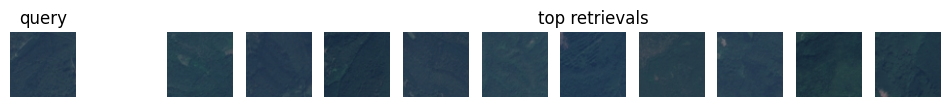

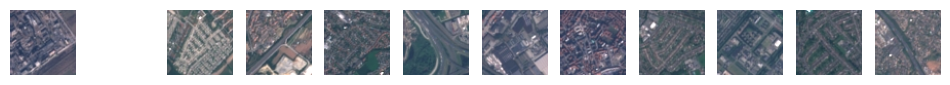

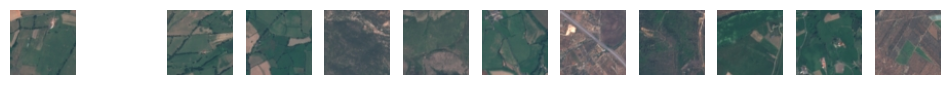

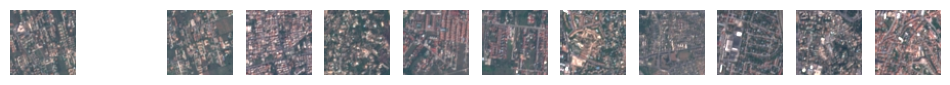

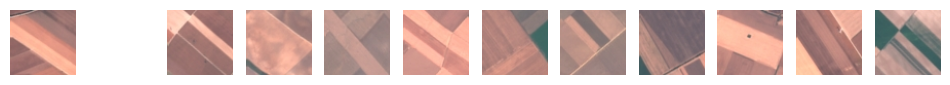

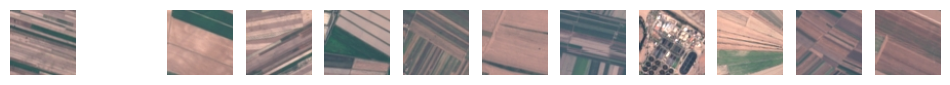

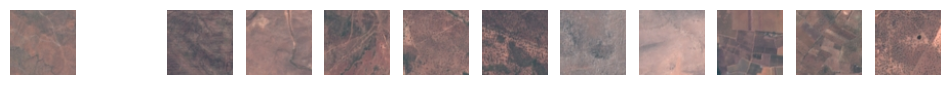

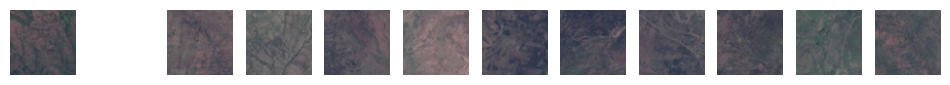

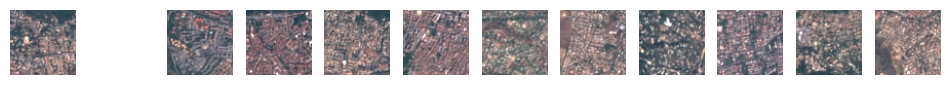

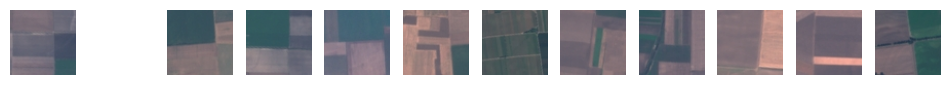

In [21]:
for i in range(10):
    topk = 10
    plt.figure(figsize=(12, 1))
    plt.subplot(1, topk+2, 1)
    plt.imshow(cvtColor(imread(Fnames[inds[i]]), COLOR_BGR2RGB))
    plt.axis("off")
    if i==0:
        plt.title("query")
    for j in range(topk):
        plt.subplot(1, topk+2, j+3)
        plt.imshow(cvtColor(imread(Fnames[sorted[i, j]]), COLOR_BGR2RGB))
        plt.axis("off")
        if i==0 and j==topk//2:
            plt.title("top retrievals")
    plt.show()